In [1]:
%load_ext autoreload
%autoreload 2

# Demonstration of image augmentation for FCU-Net
- based off of Joydeep's data augmentation, updated with s&p noise, shifting, and converting everything to numpy/cupy rather than tensorflow 
- there are some quirks regarding how he organized his tensors for doing ffts that i've left (for now), but which I can clean up once we know exactly how this will be used. 
- I also haven't ported over the elliptic transforms yet, but I'm planning on just grabbing those from py4dstem 
- this notebook gives a brief demo using a few images from the training set

In [2]:
import numpy as np
import cupy as cp
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import os

from augment4D.augment import Image_Augmentation

In [3]:
from hipl.utils import show_im
import scipy.ndimage as ndi

# Helpers

In [4]:
def change_root_path(row, rot_path, unrot_path):
    '''
    changes the root path of '/data/...' to whatever the correct file path is while keeping the nested file structure

    row: pandas series
    rot_path: Path or str to the top level dir ml-ai-4dstem-main
    unrot_path: Path or str to the top level dir ml-ai-4dstem-main-unrotated
    '''
    # get the paths for sims and training datasets

    s_training = str(row.training_name)
    s_sim = str(row.filenameOutput)
    # check if its unrotated
    # if its not unrotated we need to set the path to rot_path
    if not row.rotation_type == 'unrotated':
        s_training = Path(s_training.replace('/data', rot_path))
        s_sim = Path(s_sim.replace('/data', rot_path))
    # if its unrotated we need to set to unrotated path
    else:
        s_training = Path(s_training.replace('/data', unrot_path))
        s_sim = Path(s_sim.replace('/data', unrot_path))

    row.training_name = s_training
    row.filenameOutput =  s_sim
    return row


# load some example data 
- same template as the demo .ipynb that Alex shared

In [5]:
unrot_path = '/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4dstem-main-unrotated'
rot_path = '/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4dstem-main'
dataframe_path = "/global/cfs/cdirs/m4269/FCU-Net_Data/full_dataframe_FCU-Net_data.pkl"

df_orig = pd.read_pickle(dataframe_path)
df = df_orig.apply(change_root_path, rot_path=rot_path, unrot_path=unrot_path, axis=1)
# df = df[df.training_name.apply(os.path.exists)]
df

,mat_id,query_time,space_group_number,space_group_symbol,space_group_system,pretty_formula,full_formula,average_distance,density,atomic_numbers,average_atomic_number,pymatgen_version,script_name,row_id,name,uuid,filename,rotation_type,structure_save_name,cell_size,rotation_seed,loop_count,numpy_version,uvw,u,v,w,seed,angles,theta_1,phi,theta_2,filenameOutput,probeSemiangle,alphaBeamMax,numFP,E0,probeDefocus,sliceThickness,potBound,no_pixels,numSlices,realspacePixelSizeX,realspacePixelSizeY,simulation_seed,algorithm,simulation_program,training_name
0,mp-1186898,1.623736e+09,187,P-6m2,hexagonal,RbYb,Rb1Yb1,4.515849,3.606859,"[37, 70]",53.500000,2022.0.8,scrape_materials_project.py,51,name,0003bd29-4cff-4172-88d5-ac7b61aab08c,0003bd29-4cff-4172-88d5-ac7b61aab08c.xyz,free,/data/free/10/0003bd29-4cff-4172-88d5-ac7b61aa...,"[50, 50, 500]",NaN,4.0,1.20.1,None,NaN,NaN,NaN,9548386.0,"[136.77921658623745, -46.05732042321921, -124....",136.779217,-46.05732,-124.806385,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...,1,2,1,300,0,2,2,"[512, 512]",10,0.097656,0.097656,23276348,multislice,pyprismatic,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...
1,mp-1186898,1.623736e+09,187,P-6m2,hexagonal,RbYb,Rb1Yb1,4.515849,3.606859,"[37, 70]",53.500000,2022.0.8,scrape_materials_project.py,51,name,0003bd29-4cff-4172-88d5-ac7b61aab08c,0003bd29-4cff-4172-88d5-ac7b61aab08c.xyz,free,/data/free/10/0003bd29-4cff-4172-88d5-ac7b61aa...,"[50, 50, 500]",NaN,4.0,1.20.1,None,NaN,NaN,NaN,9548386.0,"[136.77921658623745, -46.05732042321921, -124....",136.779217,-46.05732,-124.806385,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...,2,4,1,300,0,2,2,"[512, 512]",10,0.097656,0.097656,73773667,multislice,pyprismatic,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...
2,mp-1186898,1.623736e+09,187,P-6m2,hexagonal,RbYb,Rb1Yb1,4.515849,3.606859,"[37, 70]",53.500000,2022.0.8,scrape_materials_project.py,51,name,0003bd29-4cff-4172-88d5-ac7b61aab08c,0003bd29-4cff-4172-88d5-ac7b61aab08c.xyz,free,/data/free/10/0003bd29-4cff-4172-88d5-ac7b61aa...,"[50, 50, 500]",NaN,4.0,1.20.1,None,NaN,NaN,NaN,9548386.0,"[136.77921658623745, -46.05732042321921, -124....",136.779217,-46.05732,-124.806385,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...,4,8,1,300,0,2,2,"[512, 512]",10,0.097656,0.097656,25301810,multislice,pyprismatic,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...
3,mp-554159,1.623736e+09,20,C222_1,orthorhombic,Li2BeSiO4,Li4Be2Si2O8,2.822708,2.577862,"[3, 3, 3, 3, 4, 4, 14, 14, 8, 8, 8, 8, 8, 8, 8...",7.000000,2022.0.8,scrape_materials_project.py,958,name,000675f8-59ef-4a57-94ec-a72059d9bc8d,000675f8-59ef-4a57-94ec-a72059d9bc8d.xyz,zone,/data/zone/191/000675f8-59ef-4a57-94ec-a72059d...,"[50, 50, 500]",73817505.0,3.0,1.20.1,"[2, 0, 1]",2.0,0.0,1.0,NaN,None,NaN,NaN,NaN,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...,1,2,1,300,0,2,2,"[512, 512]",10,0.097656,0.097656,5497809,multislice,pyprismatic,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...
4,mp-554159,1.623736e+09,20,C222_1,orthorhombic,Li2BeSiO4,Li4Be2Si2O8,2.822708,2.577862,"[3, 3, 3, 3, 4, 4, 14, 14, 8, 8, 8, 8, 8, 8, 8...",7.000000,2022.0.8,scrape_materials_project.py,958,name,000675f8-59ef-4a57-94ec-a72059d9bc8d,000675f8-59ef-4a57-94ec-a72059d9bc8d.xyz,zone,/data/zone/191/000675f8-59ef-4a57-94ec-a72059d...,"[50, 50, 500]",73817505.0,3.0,1.20.1,"[2, 0, 1]",2.0,0.0,1.0,NaN,None,NaN,NaN,NaN,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...,2,4,1,300,0,2,2,"[512, 512]",10,0.097656,0.097656,52305848,multislice,pyprismatic,/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4ds...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33295,mp-765191,1.623736e+09,14,P2_1/c,monoclinic,LiAgF4,Li4Ag4F16,3.477063,4.090207,"[3, 3, 3, 3, 47, 47, 47, 47, 9, 9, 9, 9, 9, 9,...",14.333333,2022.0.8,scrape_materials_project.py,878,name,ffa04d43-214e-4117-b789-93d2088b9657,ffa04d43-214e-4117-b789-93d2088b965

In [6]:
# select just some of the data as an example
# row = df.iloc[0]
row = df[(df.mat_id == 'mp-1186898') & (df.probeSemiangle > 2) & (df.rotation_type == 'unrotated')].iloc[0]

In [7]:
# load the cbed patterns and probes
with h5py.File(row.training_name, 'r') as f:
    print(f.keys())
    cbeds = f['dataMeas'][...]
    thicknesses = f['thicknesses'][...]
    probe = f['dataProbe'][...]
    pots = f['dataPots'][...]

<KeysViewHDF5 ['dataMeas', 'dataPots', 'dataProbe', 'dataQz', 'qx', 'qy', 'qz', 'thicknesses']>


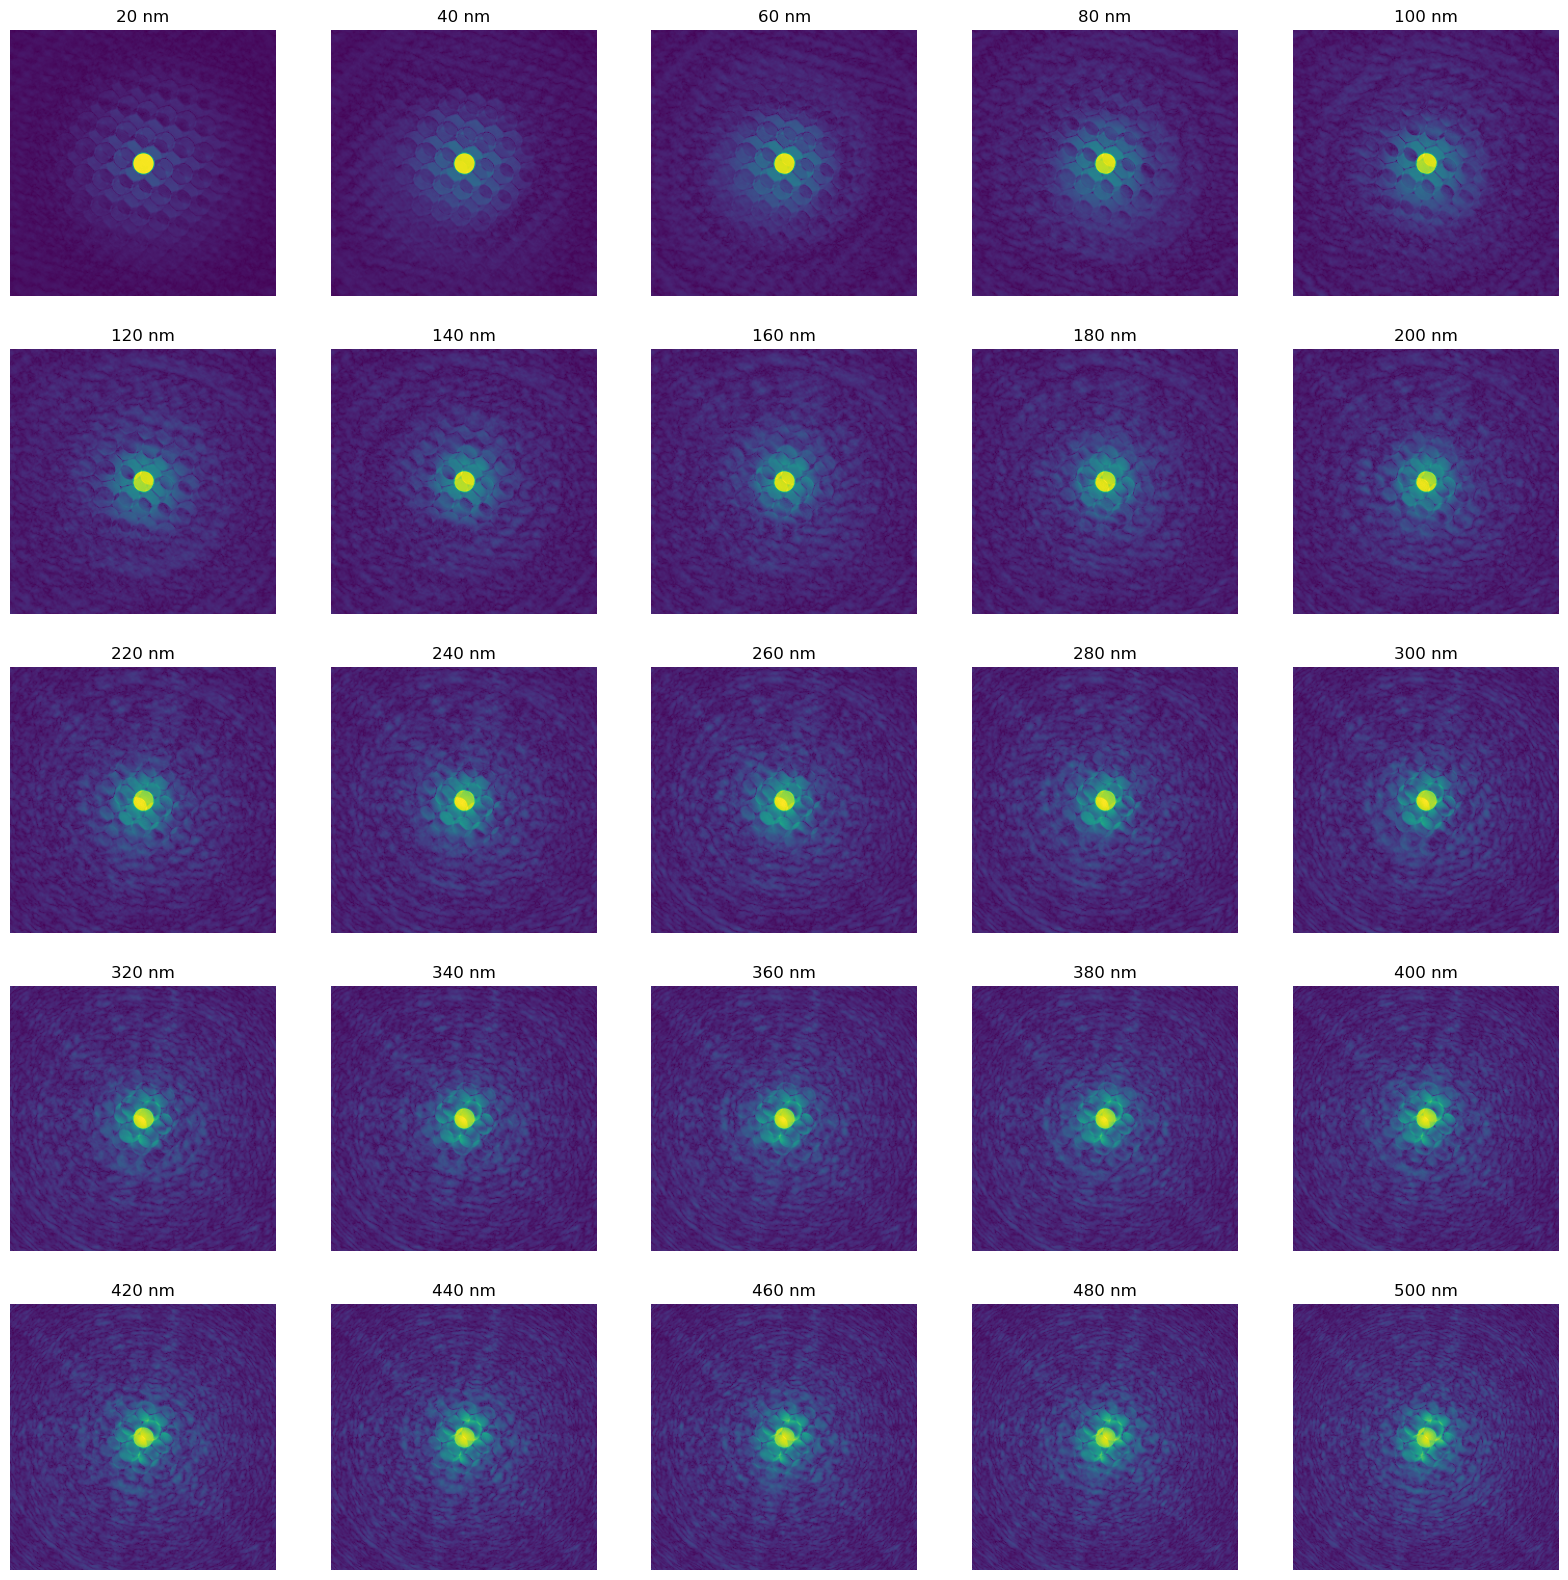

In [8]:
fig, ax = plt.subplots(5,5, figsize=(20,20))

axes = ax.ravel()

for i in range(25):
    axes[i].imshow(cbeds[...,i]**0.25)
    axes[i].set_title(f'{thicknesses[i]} nm')
    axes[i].set_axis_off()

plt.show()

# Image augmentation

In [9]:
device = 'cpu'
augmentor = Image_Augmentation(
        add_background=True,
        weightbackground=0.05,
        qBackgroundLorentz=0.05,
        add_shot=True,
        counts_per_pixel=1e4,
        add_pattern_shift=True,
        xshift=5.5,
        yshift=5.5,
        add_ellipticity=True,
        ellipticity_scale=5e-2,
        add_salt_and_pepper=True,
        salt_and_pepper_scale=1e-4,
        verbose=False,
        log_file="./logs/augment_log.csv",
        device=device,
)

The original augmentation for crystal4D expected the input shape to be: (batch, height, width, channel)    
which is logical, but the tf tensors were kept in a different format, hence the transposing here. This can/should be adapted to whatever convention you're using. 

Also, it seems like the previous method augmented the entire batch using the same parameters (rather than a range of parameters). This seems a bit odd to me, but I haven't changed it yet. There were also a few parameters that were strangely hardcoded, and these I have updated. 

In [10]:
cbeds_input = np.transpose(cbeds, (2,1,0))[...,None]

cbeds_aug = augmentor.augment_img(cbeds_input, probe[None,...,None])
if device == "gpu": 
    cbeds_aug = cbeds_aug.get()
cbeds_aug = np.transpose(cbeds_aug.squeeze(), (2,1,0))

augmentor.get_params()

Printing augmentation summary... 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 
Weighted background: 0.05
Background plasmon: 0.05
Counts per pixel: 1.0e+04
Pattern shift: 5.5,5.5
Ellipticity scaling: 0.05
Ellipticity params (exx, eyy, exy): (1.07, 1.00, -0.01)
Salt & pepper scaling: 1.0e-04
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 


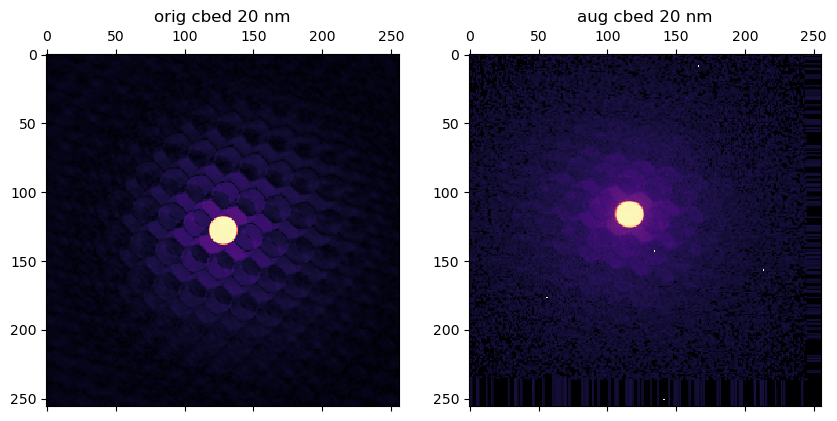

In [11]:
i = 0 
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].matshow(cbeds[...,i]**0.25, cmap='magma')
axs[0].set_title(f"orig cbed {thicknesses[i]} nm")

axs[1].matshow(cbeds_aug[...,i]**0.25, cmap='magma')
axs[1].set_title(f"aug cbed {thicknesses[i]} nm")
plt.show()

we also need to apply the same augmentations to the potential and probe

In [12]:
augmentor.add_background = False 
augmentor.add_shot = False 
probe_aug = augmentor.augment_img(probe[None,...,None]).squeeze()

pots_input = np.transpose(pots, (2,1,0))[...,None]
pots_aug = augmentor.augment_img(pots_input)

if device == "gpu": 
    probe_aug = probe_aug.get()
    pots_aug = pots_aug.get()

pots_aug = np.transpose(pots_aug.squeeze(), (2,1,0))


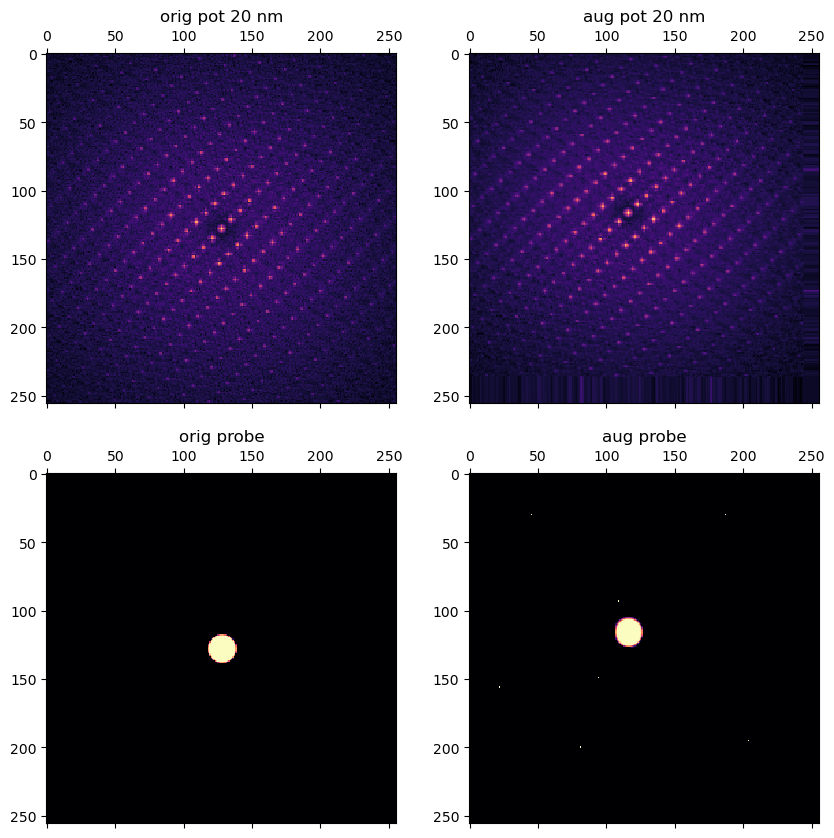

In [13]:
i = 0 
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axs[0,0].matshow(pots[...,i]**0.25, cmap='magma')
axs[0,0].set_title(f"orig pot {thicknesses[i]} nm")

axs[0,1].matshow(pots_aug[...,i]**0.25, cmap='magma')
axs[0,1].set_title(f"aug pot {thicknesses[i]} nm")

axs[1,0].matshow(probe**0.25, cmap='magma')
axs[1,0].set_title(f"orig probe")

axs[1,1].matshow(probe_aug**0.25, cmap='magma')
axs[1,1].set_title(f"aug probe")

plt.show()